In [90]:
import numpy as np  # linear algebra
import pandas as pd  #
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy.stats import norm, skew,boxcox_normmax, probplot#for some statistics
from scipy.special import boxcox1p
from sklearn.linear_model import LassoCV, RidgeCV, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import mean_squared_error


In [2]:
train = pd.read_csv('src/train.csv')
test = pd.read_csv('src/test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


In [3]:
train_ID = train['Id']
test_ID = test['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

### DATA RELATIONSHIP

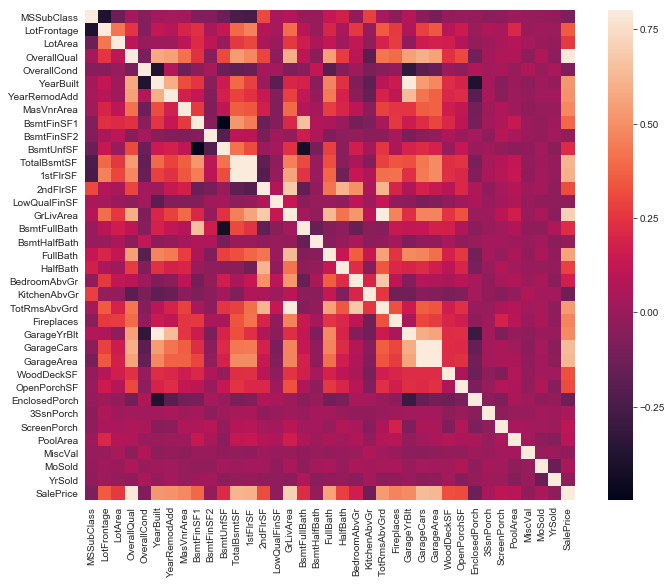

In [4]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

We can note that both `BsmtUnfSF` and `1stFlrSF` have high correlation on `SalePrice` and those two have high correlation to each other. The similar relationship happens between a pair of attributes `GarageCars`, `GarageArea` and the target `SalaPrice`. In other words, the dataset might have multi-colinear relationships between some pairs of attributes and the target. We can remove one attribute while keeping the other in the pair because the features are redundant and give the same information.

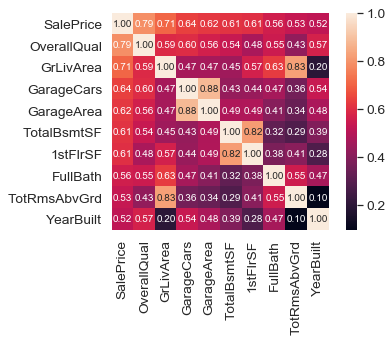

In [5]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

For better visualization, we decide to zoom the heatmap by looking at the top 10 attributes which are most correlated to the `SalePrice`. The knowledge which can extract from this visualization is that :
* `OverallQual` and `GrLivArea` have the highest correlation co-efficient with the `SalePrice`.
* `GarageCars` and `GarageArea` are highly correlated to each other. If we know the `GarageArea`, we can roughly estimate the number of cars that can fit in. Therefore, they provide redundant information => Eliminate one of them
* `1stFlrSF` and `TotalBsmtSF` are another twins brother. In fact, the area of the basement can be used to infer the area of the first floor.

Scatterplot is a useful visualization for bivariate analysis to show the correlation between variables and target value. We will plot a graph of `GrLivArea` and `SalePrice` because `GrLivArea` has the high correlation with `SalePrice`

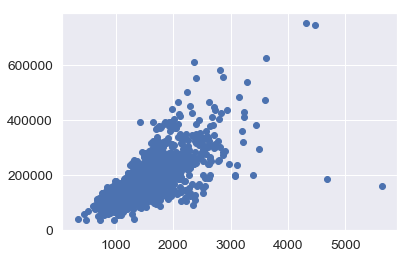

In [6]:
plt.scatter(train.GrLivArea, train.SalePrice)
plt.savefig('GrLivArea vs SalePrice.png')

There are two unusual points with high `GrLivArea`>4500 which has low `SalePrice`. It does not follow the pattern of positive correlation between two variables. We decide to remove it because it has extremely large area while having low sale price.
There might be other outliers, but we cannot identify every single of them and determine if they are valuable or not. We will adopt a Regression model which is robust to outliers

In [7]:
# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

### ANLYZE SALEPRICE
We have to understand our target in order to move closer toward it

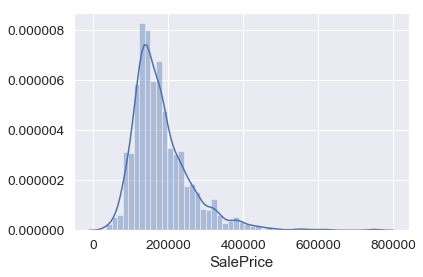

In [8]:
sns.distplot(train['SalePrice']);

The data distribution follows unimodal data distribution with a high peak at around 110000. Additionally, data distribution on 'SalePrice' has a property of positive skewness.
Note that one of the key assumptions of Regression model is the Homoscedasticity. Homoscedasticity refers to the concept that the model commits the same error's variance, i.e, the regression model does not have small errors for low values of variables $X$ and big errors for the higher values of $X$. In other words, the model's prediction $\hat{y}$ has the constant error from the true target $y$ for all variable $X$.
Therefore, we need to normalize the data distribution of target value into Gaussian distribution by applying Log transformation


In [9]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(train["SalePrice"]).reset_index(drop=True)


 mu = 12.02 and sigma = 0.40



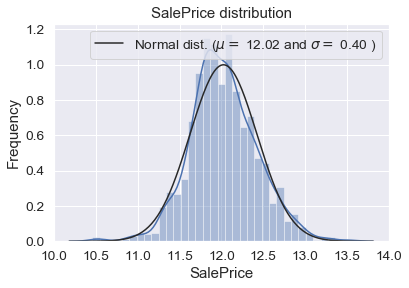

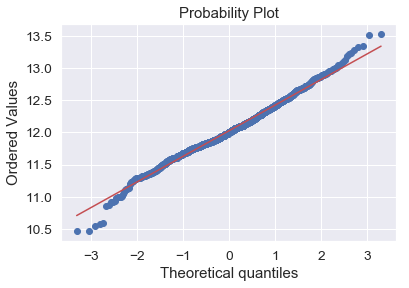

In [10]:
#Check the new distribution 
sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.savefig('SalePrice_Distribution.png')

#Get also the QQ-plot
fig = plt.figure()
res = probplot(y_train, plot=plt)
plt.savefig('QQplot.png')

### Missing Data:
* How prevalent is the missing data
* Is there any pattern or are they randomly missing?

Merge training and testing data to impute missing data

In [11]:
ntrain = train.shape[0]
ntest = train.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


#### Convert non-numeric predictors
While ordinality within `YearBuilt` and `YearRemodAdd` makes sense because the new house can be more expensive than old house, Year and Month Sold's ordinality does not affect the `SalePrice`. 
We will consider Year and Month  as categorical because the increasing of Year does not necessarily increase or decrease the SalePrice. In fact, there is no strong correlation between SalePrice and the order of the Year. 

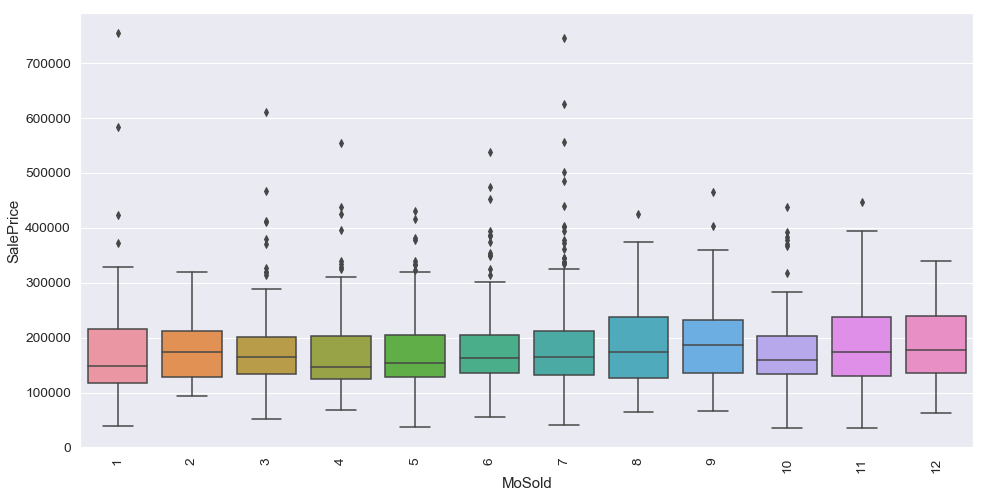

In [12]:
var = 'MoSold'
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=train)
plt.xticks(rotation=90);

In [13]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### LISTING MISSING DATA

In [14]:
#missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5,1,'Percent missing data by feature')

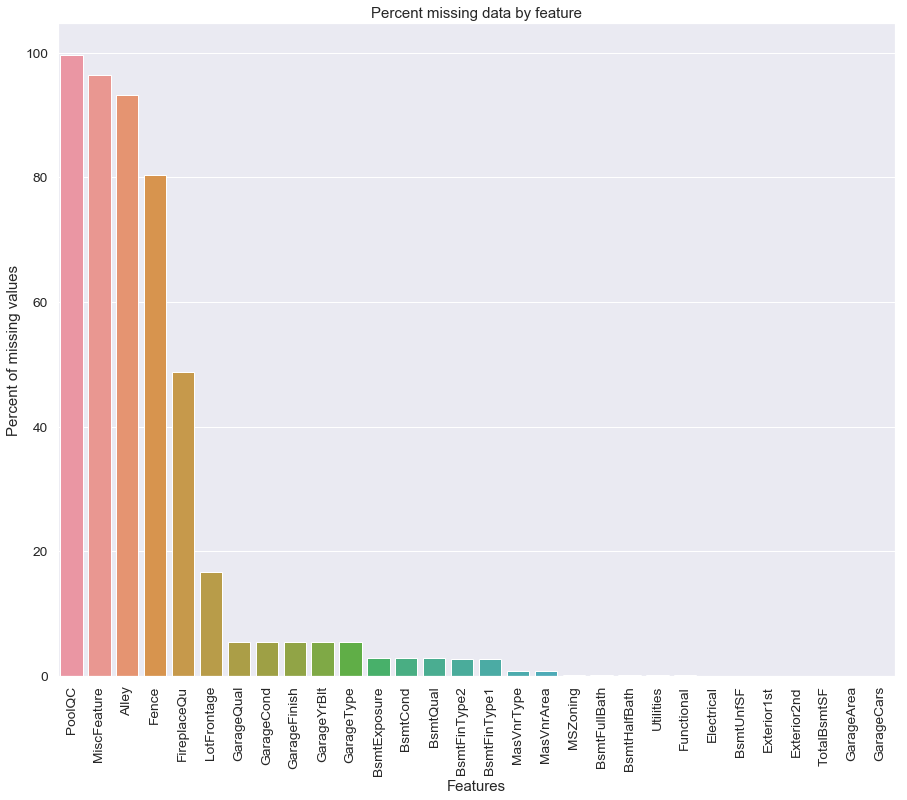

In [15]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

`PoolQC` refers to the Pool quality and we can easily explain the high number of missing data by the fact that only the minority of house have pools.

In [16]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

<b> Garage Variables </b>
There are 159 NAs for `GarageFinish`, `GarageQual`, `GarageCond`, `GarageYrBlt` while there are only 157 NAs for GarageType.
Therefore, two houses actually have Garage but their Garage information is missing while the other 157 houses might not have Garage.

In [17]:
condition = all_data['GarageFinish'].isnull() & all_data['GarageType'].notnull()
all_data[condition][['GarageFinish','GarageQual','GarageYrBlt','GarageType']]

,GarageFinish,GarageQual,GarageYrBlt,GarageType
2124,NaN,NaN,NaN,Detchd
2574,NaN,NaN,NaN,Detchd


We will handle these two records differently: 
* Replace `GarageFinish`,`GarageQual`,`GarageCond` by the mode value (most frequent value) of that attribute
* Replace `GarageYrBlt` with the `YearBuilt` of the house

In [18]:
for col in ('GarageFinish','GarageQual','GarageCond'):
    all_data.loc[condition,col] = all_data[col].mode()[0]

all_data.loc[condition,'GarageYrBlt'] = all_data.loc[condition,'YearBuilt']

In [19]:
# Now we can impute the other NAs of Garage variables with "None" as they potentially refer to the house without Garage
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')
    
# For the numeric `Garage attributes, we fill NAs with zero value
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

`LotFrontage` is the area of the street connected to the house property. Note that this attribute might be similar among all houses in the same neighborhood, we can impute the missing values by using the median `LotFrontage` of the Neighborhood

In [20]:
# all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
#     lambda x: x.fillna(x.median()))
df_tmp = train.groupby("Neighborhood")["LotFrontage"].median().reset_index(name="MedianLotFrontage")
df_merge = all_data.merge(df_tmp,on="Neighborhood",how="left")
cond = df_merge['LotFrontage'].isnull()
df_merge['LotFrontage'] = df_merge['LotFrontage'].fillna(df_merge["MedianLotFrontage"])
all_data = df_merge.drop(columns="MedianLotFrontage")

The same logic applies on `MSZoning` which can be inferred from the mode value within the same `MSSubclass`.
UNFORTUNATELY, the MSZoning in the SubClass 30 and 40 have two MSZoning values with the same frequency which are `RL` and `RM`

In [21]:
train.groupby("MSSubClass")["MSZoning"].agg(pd.Series.mode).reset_index(name="ModeZoning")

,MSSubClass,ModeZoning
0,20,RL
1,30,"[RL, RM]"
2,40,"[RL, RM]"
3,45,RM
4,50,RL
5,60,RL
6,70,RL
7,75,RM
8,80,RL
9,85,RL


We don't want to toss a coin and pick either one of them. Therefore, we decide to build a classifier to predict the missing values of `MSZoning` based on variables which are likely to have a relationship with `MSZoning` based on our intuition. We decide to build a Random Forest which is an ensemble of 100 individual decision trees to predict the `MSZoning` based on `MSSubClass`, `NeighborHood`, `BldgType` and `HouseStyle`.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
variables = ["MSSubClass","Neighborhood","BldgType","HouseStyle"]
non_missing_mszoning = train[train["MSZoning"].notnull()]
clf = make_pipeline(OneHotEncoder(handle_unknown="ignore"),RandomForestClassifier(n_estimators=100, max_depth=3))
clf.fit(non_missing_mszoning[variables],non_missing_mszoning["MSZoning"])
print("Random Forest Mean Accuracy for 5 runs of cross validation")
np.mean(cross_val_score(clf,non_missing_mszoning[variables],non_missing_mszoning["MSZoning"],cv=5))

Random Forest Mean Accuracy for 5 runs of cross validation


0.8093495558556043

The Mean Accuracy after running cross validations with 5 folds is 80% which means that we can 80% believe in the predicted `MSZoning` of our Random Forest rather than just 50 by 50 picking one Mode values. 

In [23]:
cond = all_data["MSZoning"].isnull()
all_data[cond]["MSZoning"] = clf.predict(all_data[cond][variables])

Fill NAs in the attributes which can be similar to the mode value value of that attribute

In [24]:
all_data['Functional'] = all_data['Functional'].fillna(all_data['Functional'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [25]:
all_data[all_data['BsmtUnfSF'].isnull()][['BsmtUnfSF','BsmtQual','BsmtFullBath','BsmtHalfBath']]

,BsmtUnfSF,BsmtQual,BsmtFullBath,BsmtHalfBath
2118,NaN,NaN,NaN,NaN


`Utilities`: Since all values are `AllPub`, except for one `NoSeWa` and 2 NA rows, this attribute does not provide useful information for our predictive model. Furthermore, only one row `NoSeWa` might be an outlier which could lead to an overfitting problem if our model has high capacity. We can safely remove this attribute

In [26]:
all_data.drop(['Utilities'],axis=1,inplace=True)

For the remaining categorical attributes, fill NAs with "None"

In [27]:
objects = []
for i in all_data.columns:
    if all_data[i].dtype == object:
        objects.append(i)

all_data.update(all_data[objects].fillna('None'))

For the remaining numeric attributes, fill the NA with 0

In [28]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numerics.append(i)
all_data.update(all_data[numerics].fillna(0))

### DATA TRANSFORMATION

<b> Pre-process Skewed Data </b>

In [29]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_features = all_data[:ntrain][numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skew_features})
skewness.head(10)

,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895
EnclosedPorch,3.083987


Box Cox transformation is more effective than using Log Transformation because Box Cox considers different transformation function to normalize skewed data.
Box Cox transforms data distribution using different $lambda$, when $lambda=1$, we get Log transformation

In [30]:
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    all_data[i] = boxcox1p(all_data[i], boxcox_normmax(all_data[i] + 1))

#### Feature Construction

Some helper function to find boxplot and correlation between new constructed variable and `SalePrice`

In [31]:
def corr_newvar(var):
    data = pd.concat([all_data[:ntrain],train['SalePrice']],axis=1)
    print(data[var].corr(data['SalePrice']))
def boxplot_newvar(var):
    data = pd.concat([all_data[:ntrain],train['SalePrice']],axis=1)
    f, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(x=var, y="SalePrice", data=data)
    plt.xticks(rotation=90);

<b> Total Area </b> 

Since area-related feature is important to predict sale price, we can add total area of Basement, 1st Floor and 2nd Floor together.

In [32]:
# Adding total sq footage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
corr_newvar('TotalSF')

0.545908822722034


There are 4 bathroom variables and each individual variable does not have high predictability. However, when add them up into one predictor, we can derive a strong predictor

In [33]:
all_data['TotalBathrooms'] = all_data['FullBath'] + 0.5 * all_data['HalfBath'] + \
                            all_data['BsmtFullBath'] + 0.5*all_data['BsmtHalfBath']

Correlation : 
0.6373361977784624


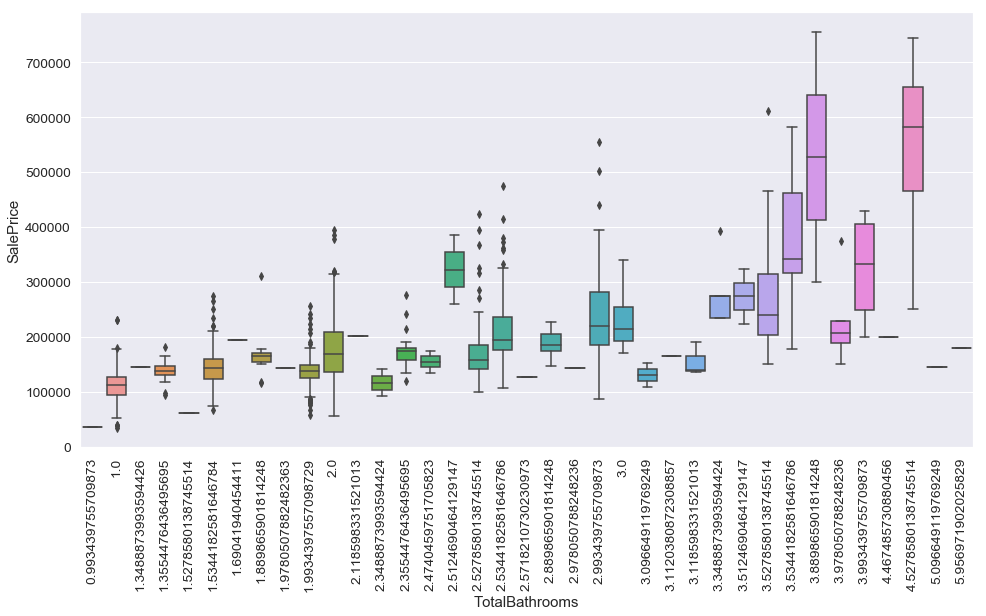

In [34]:
print("Correlation : ")
corr_newvar('TotalBathrooms')
boxplot_newvar('TotalBathrooms')
plt.savefig('TotalBathrooms.png')

<b>House Age</b>
The age of the house can be calculated as `YrSold` - `YearBuilt`. 
`Age` is one of the important feature of the house used to set the price

In [35]:
all_data['Age'] = all_data['YrSold'].astype(int) - all_data['YearBuilt']
corr_newvar('Age')

-0.5240670055640873


As the house becomes older, the `SalePrice` will drop

There is one row having Age = -1 which means that the house had been sold before it was built! That point indicates the noise which needs to be removed

In [36]:
all_data[all_data['Age'] < 0][['YearBuilt','YearRemodAdd','YrSold','Age']]

,YearBuilt,YearRemodAdd,YrSold,Age
2547,2008,2009,2007,-1


In [37]:
all_data = all_data[all_data['Age'] >= 0]

The other useful combination of features are 

In [38]:
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd'] # Combine YearBuilt and Year Remodelling

all_data['TotalSF2'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF']) # Use different Bsmt Area metrics

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF']) # Calculate the area of the Porch

We can explicitly tell the model to increase or decrease the price by the common conditions of the house such as: is the house new, is it just remodeled to be more modern, does it have bathroom, garage, etc. It can be done by adding the simplified features based on its corresponding measurements

In [39]:
# simplified features
all_data['IsNew'] = np.where(all_data['YrSold'] != all_data['YearBuilt'],0,1)
all_data['IsRemod'] = np.where(all_data['YearBuilt'] == all_data['YearRemodAdd'],0,1)
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

<b> One hot encoding the remaining categorical attributes</b>

In [40]:
all_data = pd.get_dummies(all_data).reset_index(drop=True)

In [41]:
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]
print("Training data ",X_train.shape, " target ",y_train.shape)
print("Testing data", X_test.shape)

Training data  (1458, 343)  target  (1458,)
Testing data (1458, 343)


<b> Removing remaining potential outliers </b>
1. Remove unmeaningful features which has the mode value more than 99.95% regardless of the `SalePrice`

In [42]:
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 > 99.95:
        overfit.append(i)
overfit

['IsNew', 'MSSubClass_150', 'MSZoning_None']

In [43]:
X_train['IsNew'].value_counts()

0    1458
Name: IsNew, dtype: int64

In [44]:
X_train.drop(columns=['IsNew','MSSubClass_150','MSZoning_None'],inplace=True)
X_test.drop(columns=['IsNew','MSSubClass_150','MSZoning_None'],inplace=True)

2. Identify the sample corresponding to the high error residual -> outliers

Since the magnitude of the ordinary residual depends on the unit of measurement, it is difficult to set a threshold and detect unusual y-values. Thereby, Standardized residual (or internally studentized residual) eliminates the unit difference by dividing the residual by the estimate of standard deviation.
https://newonlinecourses.science.psu.edu/stat501/node/339/

In [45]:
# import statsmodels.api as sm
# ols = sm.OLS(endog = y_train.values, exog = X_train.values)
# fit = ols.fit()
# test2 = fit.outlier_test()
# # In[]
# outliers = [i for i,record in enumerate(test2) if record[2] < 1e-3]
# outliers

Note that: After identifying outliers, we should record them and directly use their indices instead of re-running the statistical model each time. (Comment out the above code)

In [46]:
outliers = [30,88,462,631,1322,1451] # After all we detect 5 outliers
X_train.drop(X_train.index[outliers],inplace=True)
y_train.drop(y_train.index[outliers],inplace=True)

In [47]:
print('X_train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape)

X_train (1452, 340) y_train (1452,) X_test (1458, 340)


### Dimension Reduction for Visualization

Binning the SalePrice to convert into 3 categories: cheap, medium and expensive

In [107]:
df_tsne = pd.DataFrame()
df_tsne['SalePrice'] = pd.cut(y_train,3,labels=["cheap","medium","expensive"])

Apply PCA to decompose into 250 dimensions and further apply t-sne to transform into 2D space

In [109]:
pca_200 = PCA(n_components=250)
pca_result = pca_200.fit_transform(X_train)
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=3000)
tsne_results = tsne.fit_transform(X_train)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1452 samples in 0.011s...
[t-SNE] Computed neighbors for 1452 samples in 0.507s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1452
[t-SNE] Computed conditional probabilities for sample 1452 / 1452
[t-SNE] Mean sigma: 55.303374
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.699722
[t-SNE] KL divergence after 3000 iterations: 0.501525


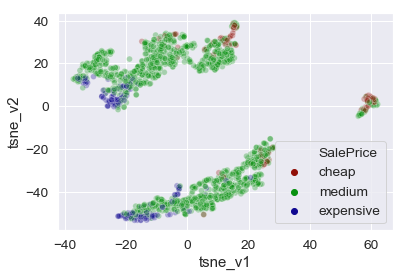

In [113]:
df_tsne['tsne_v1'] = tsne_results[:,0]
df_tsne['tsne_v2'] = tsne_results[:,1]
# Make the plot
sns.scatterplot(
    x="tsne_v1", y="tsne_v2",
    hue="SalePrice",
    palette=sns.hls_palette(3, l=.3, s=.9),
    data=df_tsne,
    legend="full",
    alpha=0.3
)

Cheap and expensive samples are quite distinctive to each other, while medium samples are mingled with both cheap and expensive samples, which may be caused the way we discretize the response variable in a relative manner, which increases the difficulty to tell medium samples apart from cheap or expensive samples. Furthermore, few expensive samples have “invaded” the region of cheap houses in the bottom island, where these data may be categorized as outlier because of their suspiciously high sale prices. Note that there existed several missing values which would be addressed in the next section.

Overall, the Dimension Reduction for visualization aids knowledge extraction about the data complexity and helps us design proper Machine Learning models giving optimal Bias-Variance benefit.
Our preprocessed data exhibits clear separability which indicates that a linear regression model with regularization could potentially have a good performance on this data according to this the complexity

<b>Export Pre-processed data</b>

In [48]:
data_train = pd.concat([X_train,pd.DataFrame(data=y_train,columns=['SalePrice'])],axis=1)
names = list(data_train)
names.remove('SalePrice')
names.append('SalePrice')
data_train = data_train[names]
data_train.to_csv('preprocessed_train.csv',index=False)
X_test.to_csv('preprocessed_test.csv',index=False)

### MODEL

Build a Ridge and Lasso models and evaluate the models using Cross Validation with 10-Folds
The main error metrics to be used is Mean Squared Error as required in the challenge description

In [56]:
print('START ML', datetime.now(), )
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def grid_search(model,param_grid=params,scoring=["neg_mean_squared_error","neg_mean_absolute_error","r2"],refit="r2"):
    gs = GridSearchCV(model,param_grid=params,scoring=scoring,refit=refit,cv=kfolds)
    gs.fit(X_train,y_train)
    results = gs.cv_results_
    print(refit," =",gs.best_score_," achieved by configuration : ",gs.best_params_)
    best_idx = np.argwhere(results['rank_test_%s' % refit] == 1)[0,0]
    for scorer in scoring:
        for sample in ('train','test'):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)][best_idx]
            print(sample,"_",scorer,":",sample_score_mean)
    return gs

# build our model scoring function
def cv_rmse(model, X_train=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    
    return (rmse)

START ML 2019-05-07 18:14:05.053826


The RobustScaler is applied to transform scale the data based on the percentile which is robust to the outliers.
`RidgeCV()` and `LassoCV` takes the list of parameters to be tuned and the defined k-folds (we use 10-folds). After that, the best configuration of parameters giving the best "scoring" (mean squared error in our case) is identified at the end

In [55]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds,))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

TEST score on CV
Kernel Ridge score: 0.1003 (0.0128)
 2019-05-06 22:50:08.696656
Lasso score: 0.0989 (0.0121)
 2019-05-06 22:50:19.210914


We can build a complete pipeline to feed the RobustScaler, feed our custom models to tune the parameters and show the configuration of parameters giving the best result

In [ ]:
# Lasso
lasso = Pipeline([
            ('rs',RobustScaler()),
            ('lasso',Lasso(max_iter=1e7))
        ])
params = {"lasso__alpha":np.linspace(1e-5,1e-3,50)}
gs_lasso = grid_search(lasso,params)

In [52]:
# Linear Kernel Ridge
kr_linear = Pipeline([
            ('rs',RobustScaler()),
            ('kr',KernelRidge(kernel="linear"))
        ])
params = {"kr__alpha":np.linspace(0,1e-1,100)}
gs_linear=grid_search(kr_linear,params)

neg_mean_squared_error  = -0.01405132040993836  achieved by configuration :  {'kr__alpha': 0.1}
train _ neg_mean_squared_error : -0.006149041942469273
test _ neg_mean_squared_error : -0.01405132040993836
train _ neg_mean_absolute_error : -0.05759052711421715
test _ neg_mean_absolute_error : -0.0806613545826184
train _ r2 : 0.9608954110596601
test _ r2 : 0.9100526693841099


In [53]:
# Polynomial Kernel Ridge
kr_poly = Pipeline([
            ('rs',RobustScaler()),
            ('kr',KernelRidge(kernel="polynomial"))
        ])
params={"kr__alpha":np.linspace(1e-2,1e-1,20),"kr__degree":[2,3]}
gs_poly = grid_search(kr_poly,params)

neg_mean_squared_error  = -0.010799129032128386  achieved by configuration :  {'kr__alpha': 0.1, 'kr__degree': 2}
train _ neg_mean_squared_error : -0.004471958489622374
test _ neg_mean_squared_error : -0.010799129032128386
train _ neg_mean_absolute_error : -0.0480241560167242
test _ neg_mean_absolute_error : -0.07251289559935965
train _ r2 : 0.9715539806082552
test _ r2 : 0.9307240256308397
